**DO NOT FORGET TO CHANGE RUNTIME TO GPU BEFORE RUNNING THIS CODE**

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')



batch_size = 128

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=ToTensor())
test_dataset = datasets.MNIST('./data', train=False, transform=ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader =  DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)




Using PyTorch version: 2.2.1+cu121
No GPU found, using CPU instead.
Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 53295771.08it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 1444533.54it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 13810845.55it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5475863.40it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Define functions to calculate model accuracy

In [2]:
def correct(output, target):
    predicted_digits = output.argmax(1)                            # pick digit with largest network output
    correct_ones = (predicted_digits == target).type(torch.float)  # 1.0 for correct, 0.0 for incorrect
    return correct_ones.sum().item()


def test(test_loader, model, criterion):
    model.eval()

    num_batches = len(test_loader)
    num_items = len(test_loader.dataset)

    test_loss = 0
    total_correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            # Copy data and targets to GPU
            data = data.to(device)
            target = target.to(device)

            # Do a forward pass
            output = model(data)

            # Calculate the loss
            loss = criterion(output, target)
            test_loss += loss.item()

            # Count number of correct digits
            total_correct += correct(output, target)

    test_loss = test_loss/num_batches
    accuracy = total_correct/num_items

    return accuracy

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        # 28*28 - 26*26*16 - 24*24*32 - 12*12*32
        self.fc1 = nn.Linear(4608, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output

In [5]:
from torchsummary import summary


model = CNN().to(device)

summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
            Conv2d-2           [-1, 32, 24, 24]           4,640
           Dropout-3           [-1, 32, 12, 12]               0
            Linear-4                  [-1, 128]         589,952
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 596,042
Trainable params: 596,042
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 2.27
Estimated Total Size (MB): 2.54
----------------------------------------------------------------


In [6]:
epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
losses = []
accs = []

for epoch in range(epochs):
    print(f"Training epoch: {epoch+1}")
    model.train()

    num_batches = len(train_loader)
    num_items = len(train_loader.dataset)


    total_loss = 0
    total_correct = 0
    for data, target in train_loader:
        # Copy data and targets to GPU
        data = data.to(device)
        target = target.to(device)

        # Do a forward pass
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target)
        total_loss += loss

        # Count number of correct digits
        total_correct += correct(output, target)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    train_loss = total_loss/num_batches
    accuracy = total_correct/num_items
    # losses.append(train_loss)
    acc1 = test(test_loader, model, criterion)
    accs.append(acc1)
    losses.append(train_loss.cpu().data.numpy())
    print(f"Average loss: {train_loss:7f}, Train accuracy: {accuracy:.2%}, Test accuracy: {acc1:.2%}")

Training epoch: 1
Average loss: 1.630850, Train accuracy: 83.89%, Test accuracy: 95.67%
Training epoch: 2
Average loss: 1.516015, Train accuracy: 94.86%, Test accuracy: 97.77%
Training epoch: 3
Average loss: 1.500682, Train accuracy: 96.21%, Test accuracy: 97.88%
Training epoch: 4
Average loss: 1.495040, Train accuracy: 96.71%, Test accuracy: 98.19%
Training epoch: 5
Average loss: 1.490692, Train accuracy: 97.15%, Test accuracy: 98.56%
Training epoch: 6
Average loss: 1.489366, Train accuracy: 97.25%, Test accuracy: 98.59%
Training epoch: 7
Average loss: 1.487037, Train accuracy: 97.49%, Test accuracy: 98.62%
Training epoch: 8
Average loss: 1.485297, Train accuracy: 97.63%, Test accuracy: 98.65%
Training epoch: 9
Average loss: 1.483570, Train accuracy: 97.80%, Test accuracy: 98.72%
Training epoch: 10
Average loss: 1.482765, Train accuracy: 97.87%, Test accuracy: 98.72%


<function matplotlib.pyplot.show(close=None, block=None)>

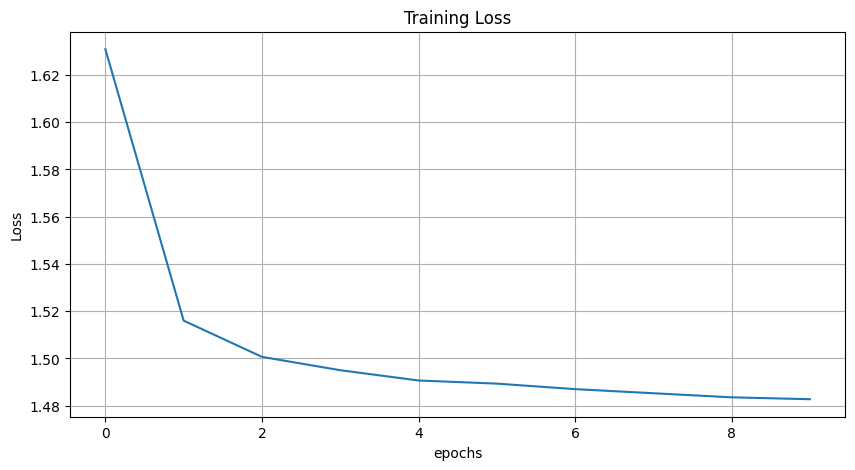

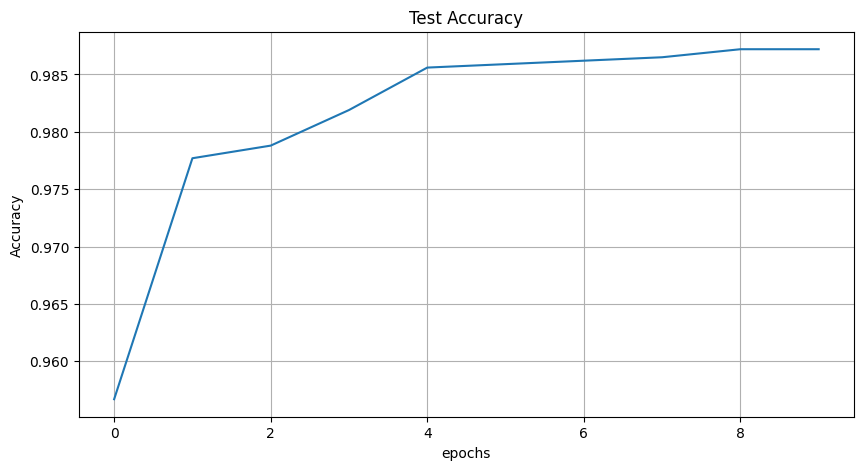

In [8]:
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.plot(losses)
plt.grid()
plt.show


plt.figure(figsize=(10,5))
plt.title("Test Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.plot(accs)
plt.grid()
plt.show

Mount Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Save Model

In [9]:
#define path to desired folder in google drive

PATH = '/content/drive/MyDrive/Colab Notebooks/my_model.pth'

torch.save(model, PATH)